# 0. Define functions and import packages

In [104]:
import pandas as pd
# Importing Libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
%matplotlib inline
plt.style.use('seaborn-dark-palette')
from scipy import stats

import datetime as dt
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet

nltk.download('punkt')
stop_words = set(stopwords.words('english')) 

import plotly
import plotly.express as px
doc_units = pd.read_excel("../../data/processed/units.xlsx")
doc_dict = dict(zip(doc_units["from"],doc_units["to"])) 

/var/folders/d7/wr0_38q17_38rmx4dysxdyfh0000gn/T/ipykernel_2367/3737874019.py:9: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-dark-palette')
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/heejinchae/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


## Vectorizor

In [105]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

## Tokenizer

In [106]:
def get_wordnet_pos(word):
    """Map POS tag to first character lemmatize() accepts"""
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}

    return tag_dict.get(tag, wordnet.NOUN)

In [107]:
def things_to_unit(a):
    "if 0.5km kind of that appears, convert to unitLength etc"
    for from_ in doc_dict:
        idx = np.where(
                 np.char.count(a,from_)==1
              )
        a[idx] = doc_dict[from_] 
    return a

In [108]:
class LemmaTokenizer:
    ignore_tokens = [',', '.', ';', ':', '"', '``', "''", '`','(',')']
    def __init__(self):
        self.wnl = WordNetLemmatizer()
    def __call__(self, doc):
        val = []
        for t in word_tokenize(doc):
            if t.isdigit():
                continue
            if (t not in self.ignore_tokens):
                val.append(
                    self.wnl.lemmatize(t,get_wordnet_pos(t))
                )
                
        return val

In [109]:
class LemmaPlaceTokenizer:
    ignore_tokens = [',', '.', ';', ':', '"', '``', "''", '`','(',')']
    def __init__(self):
        self.wnl = WordNetLemmatizer()
    def __call__(self, doc):
        val = []
        for t in word_tokenize(doc):
            if t.isdigit():
                val.append("unitN")
            elif (t not in self.ignore_tokens):
                val.append(
                    self.wnl.lemmatize(t,get_wordnet_pos(t))
                )
        new_val = np.array(val)
        new_val = np.apply_along_axis(things_to_unit, 0, new_val)
        return new_val

## Pre processor

In [110]:
def preprocess(document):
    'changes document to lower case and removes stopwords'

    # change sentence to lower case
    document = document.lower()

    # tokenize into words
    words = word_tokenize(document)

    # remove stop words & numbrs
    words = [word for word in words if word not in stopwords.words("english") or not word.isdigit()]


    # join words to make sentence
    document = " ".join(words)
    
    return document

## Let's see what are stop word

In [111]:
print(stopwords.words("english"))

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

## Load data

In [112]:
df = pd.read_excel("../../data/raw/DataCorpus_classfied_중분류_1차 연구.xlsx")

/Users/heejinchae/opt/anaconda3/envs/torch/lib/python3.9/site-packages/openpyxl/worksheet/_reader.py:312: UserWarning: Data Validation extension is not supported and will be removed
  warn(msg)


In [113]:
def add_type_column(df):
    ops = df.iloc[:, 5:-3]
    print(ops.info())
    op_type = ops[ops.columns[1:]].apply(
        lambda x: ','.join(x.dropna().astype(str)),
        axis=1
    )
    op_type=op_type.str.lower()
    df["op_type"] = op_type
    op_type = pd.DataFrame(op_type.unique(), columns=["op_type"]).sort_values(
        by="op_type",
        key=lambda x: x.str.len(),
        ignore_index=True
        )
    op_type["op_id"] = op_type.index
    op_type.to_excel("../../data/processed/op_type.xlsx")
    df = df.merge(op_type, how='left', on="op_type")
    df.to_excel("../../data/processed/corpora_w_op_type.xlsx")
    return df

In [114]:
df = add_type_column(df)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 186 entries, 0 to 185
Data columns (total 14 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Question type  186 non-null    object
 1   ordinary1      186 non-null    object
 2   ordinary2      175 non-null    object
 3   ordinary3      146 non-null    object
 4   ordinary4      73 non-null     object
 5   ordinary5      44 non-null     object
 6   ordinary6      17 non-null     object
 7   ordinary7      10 non-null     object
 8   ordinary8      3 non-null      object
 9   ordinary9      3 non-null      object
 10  ordinary10     2 non-null      object
 11  ordinary103    1 non-null      object
 12  ordinary102    1 non-null      object
 13  ordinary11     1 non-null      object
dtypes: object(14)
memory usage: 20.5+ KB
None


# 1. Type count from raw data
 Visualize initail labelled data

/Users/heejinchae/opt/anaconda3/envs/torch/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


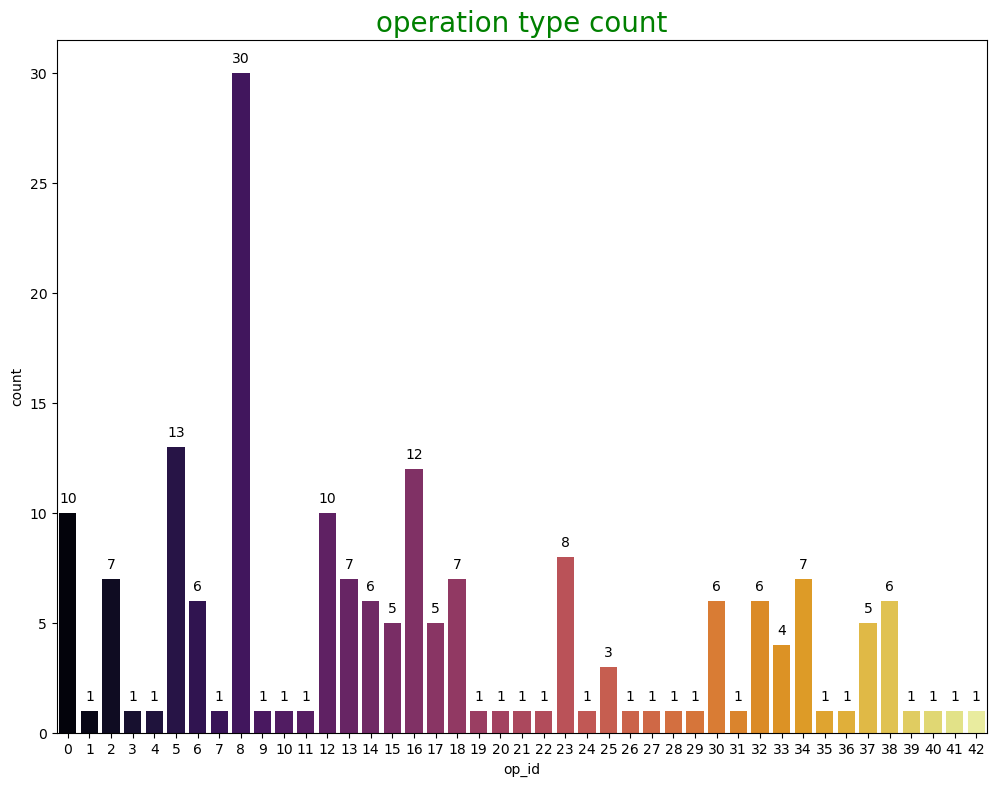

In [115]:
plt.figure(figsize=[12,9])
plot = sns.countplot(df["op_id"], palette = 'inferno')
for p in plot.patches:
    plot.annotate(format(p.get_height(),), (p.get_x() + p.get_width() / 2., p.get_height()), ha = 'center', va = 'center', xytext = (0, 10), textcoords = 'offset points')

plt.title('operation type count', fontdict={'fontsize': 20, 'fontweight': 5, 'color': 'Green'})
#plt.xticks(rotation=90)
plt.savefig("../../figures/class_and_count_initial.png", bbox_inches='tight')
plt.show()

# 2. Drop classes only with a value
 If a data is the only one in category, dropped <br />
 클래스에 해당하는 데이터가 n개 인것은 제거하기로 함. 여기서는 2개 이상으로 설정했음
 

In [116]:
df_drop_solo= df.groupby("op_id").filter(lambda x: len(x) >2)
df_drop_solo.to_excel("../../data/processed/corpora_unique_ops_dropped_wo_paraph.xlsx")

In [117]:
df_drop_solo.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 163 entries, 0 to 185
Data columns (total 24 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Question       163 non-null    object 
 1   extents        163 non-null    object 
 2   upper level    19 non-null     object 
 3   timespan       4 non-null      object 
 4   Tag In Osm     102 non-null    object 
 5   Question type  163 non-null    object 
 6   ordinary1      163 non-null    object 
 7   ordinary2      153 non-null    object 
 8   ordinary3      127 non-null    object 
 9   ordinary4      57 non-null     object 
 10  ordinary5      34 non-null     object 
 11  ordinary6      11 non-null     object 
 12  ordinary7      6 non-null      object 
 13  ordinary8      0 non-null      object 
 14  ordinary9      0 non-null      object 
 15  ordinary10     0 non-null      object 
 16  ordinary103    0 non-null      object 
 17  ordinary102    0 non-null      object 
 18  ordinary11

/Users/heejinchae/opt/anaconda3/envs/torch/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


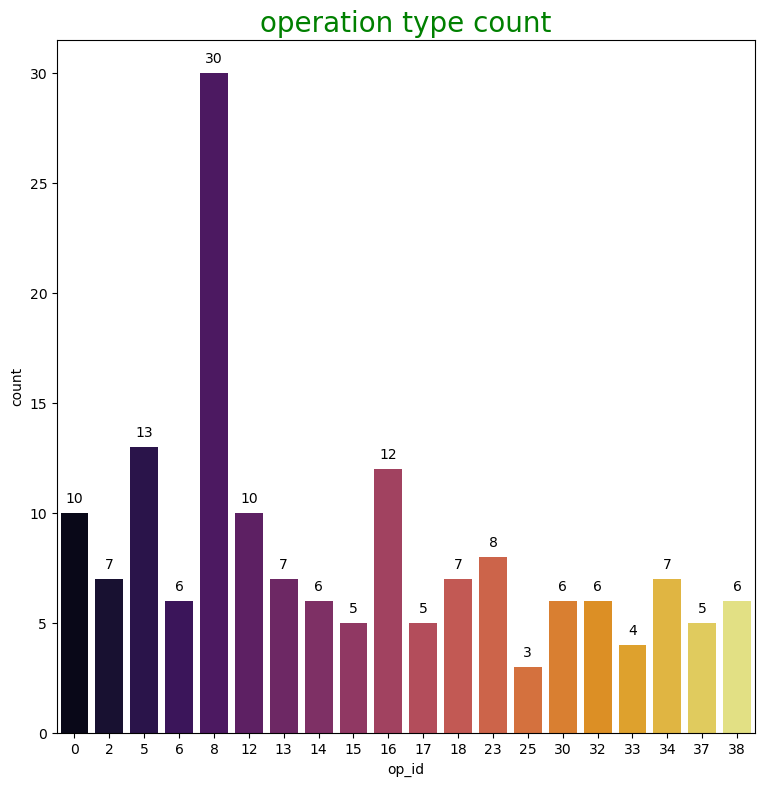

In [118]:
plt.figure(figsize=[9,9])
plot = sns.countplot(df_drop_solo["op_id"], palette = 'inferno')
for p in plot.patches:
    plot.annotate(format(p.get_height(),), (p.get_x() + p.get_width() / 2., p.get_height()), ha = 'center', va = 'center', xytext = (0, 10), textcoords = 'offset points')

plt.title('operation type count', fontdict={'fontsize': 20, 'fontweight': 5, 'color': 'Green'})
plt.savefig("../../figures/class_and_count_delete_unique_wo_paraphrase.png", bbox_inches='tight')
#plt.xticks(rotation=90)
plt.show()

In [119]:
tr_te_set = df_drop_solo
tr_te_set = tr_te_set.reset_index()
tr_te_set = tr_te_set.drop(columns=["index"])
print(tr_te_set)

                                              Question  \
0    How many buildings are within 3 minutes of dri...   
1    How many luxury hotels are in Happy Valley ski...   
2    How many streetlights for each district in San...   
3    What are the areas within a four-minute drive ...   
4    What are the four fire stations with shortest ...   
..                                                 ...   
158  Which suggested wind farm are nearest to the h...   
159  Which proposed wind farm are nearest to the hi...   
160  Which wind farm proposals are nearest to the h...   
161  Which wind farm proposals are nearest to the b...   
162  Which wind farm proposals are nearest to the r...   

                     extents upper level timespan  \
0                   Oleander         NaN      NaN   
1    Happy Valley ski resort         NaN      NaN   
2                  San Diego         NaN      NaN   
3                    Utrecht         NaN      NaN   
4              San Francisco         N

# 4. Preprocessing

In [120]:
questions = tr_te_set["Question"].str.lower()
labels = tr_te_set["op_id"]

## 4.1 Remove stopword, lemmartization etc...
 pos tag for stamming <br /> 
 ex) <br /> 
 ***before*** "The striped bats are hanging on their feet for best" -> ['The', 'striped', 'bat', 'are', 'hanging', 'on', 'their', 'foot', 'for', 'best'] <br />
 ***after*** "The striped bats are hanging on their feet for best" -> ['The', ***'strip'***, 'bat', ***'be'***, ***'hang'***, 'on', 'their', 'foot', 'for', 'best'] 
 <br />
 <br />
 Also ***delete numbers***, cause those are not that important <br />
 ex) how many buildings are within ***3*** minutes of driving time from fire stations in oleander <br /> -->
 ['how', 'many', 'building', 'be', 'within', 'minute', 'of', 'drive', 'time', 'from', 'fire', 'station', 'in', 'oleander'] <br />
 what are the four fire stations within 3 minutes of travel time from a fire in san francisco <br />
 ['what' 'be' 'the' ***'four'*** 'fire' 'station' 'within' 'unitTime' 'of' 'travel' 'time' 'from' 'a' 'fire' 'in' 'san' 'francisco']

In [121]:
# proccessed vs not processed 비교 해볼 것
# Not Preprocessed
questions_org = [question for question in questions]
# preprocessed
# questions_lem = [preprocess(question) for question in questions]
que_ = questions[5]
lemm = LemmaPlaceTokenizer()
in_ = que_
questions_lem = [" ".join(lemm(question)) for question in questions]
lo_ = 58
print(f"org:{questions_org[lo_]}, \nlem:{questions_lem[lo_]}")


org:what areas are accessible within reach two miles of urban landuse in loudoun county in us, 
lem:what area be accessible within reach unitN mile of urban landuse in loudoun county in u


## 4.2 Vectorize with TfIdf

In [122]:
# vectorizer = TfidfVectorizer()
vectorizer = TfidfVectorizer(sublinear_tf=True, min_df=1, norm='l2', encoding='utf-8',
 stop_words=None,
 )
features = vectorizer.fit_transform(questions_lem).toarray()
features.shape

(163, 291)

# 5. classify

In [123]:
tfidf = pd.DataFrame(features, columns = vectorizer.get_feature_names())
tfidf_w_question = tfidf.copy()
tfidf_w_question["Question"] = tr_te_set["Question"]
tfidf_w_question["processed_question"] = questions_lem
tfidf_w_question["op_id"] = tr_te_set["op_id"]
tfidf_w_question.to_excel("../../data/processed/tfidf_vectorized_wo_paraphrase.xlsx")

/Users/heejinchae/opt/anaconda3/envs/torch/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [124]:
Train_test_df = tfidf_w_question.drop(columns=["Question","processed_question"])
X_train, X_test, y_train, y_test = train_test_split(Train_test_df.drop(columns=["op_id"]),Train_test_df["op_id"], test_size=0.33, stratify=Train_test_df["op_id"], random_state=230)

/Users/heejinchae/opt/anaconda3/envs/torch/lib/python3.9/site-packages/sklearn/model_selection/_split.py:684: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(
/Users/heejinchae/opt/anaconda3/envs/torch/lib/python3.9/site-packages/sklearn/model_selection/_split.py:684: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(
/Users/heejinchae/opt/anaconda3/envs/torch/lib/python3.9/site-packages/sklearn/model_selection/_split.py:684: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(
/Users/heejinchae/opt/anaconda3/envs/torch/lib/python3.9/site-packages/sklearn/model_selection/_split.py:684: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


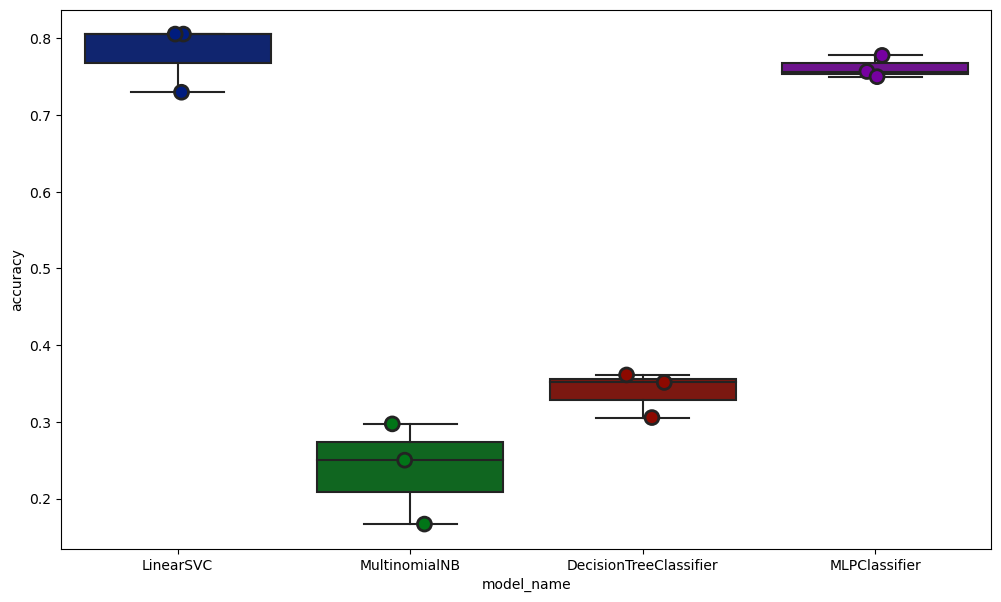

In [125]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.neural_network import MLPClassifier

models = [
    LinearSVC(),
    MultinomialNB(),
    DecisionTreeClassifier(max_depth=5),
    MLPClassifier(alpha=1, max_iter=1000),
]

CV = 3
cv_df = pd.DataFrame(index=range(CV * len(models)))

entries = []
for model in models:
    model_name = model.__class__.__name__
    accuracies = cross_val_score(model, X_train, y_train, scoring='accuracy', cv=CV)
    for fold_idx, accuracy in enumerate(accuracies):
        entries.append((model_name, fold_idx, accuracy))
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])

import seaborn as sns
plt.figure(figsize=[12,7])
sns.boxplot(x='model_name', y='accuracy', data=cv_df)
sns.stripplot(x='model_name', y='accuracy', data=cv_df, 
              size=10, jitter=True, edgecolor="gray", linewidth=2)
plt.savefig("../../figures/small_classification_wo_paraphrase.png", bbox_inches='tight')
plt.show()

In [126]:
# Accuracy score
cv_df.groupby('model_name').accuracy.mean()

model_name
DecisionTreeClassifier    0.339339
LinearSVC                 0.780280
MLPClassifier             0.761512
MultinomialNB             0.237988
Name: accuracy, dtype: float64

# Pick model and run

[0, 2, 5, 6, 8, 12, 13, 14, 15, 16, 17, 18, 23, 25, 30, 32, 33, 34, 37, 38]


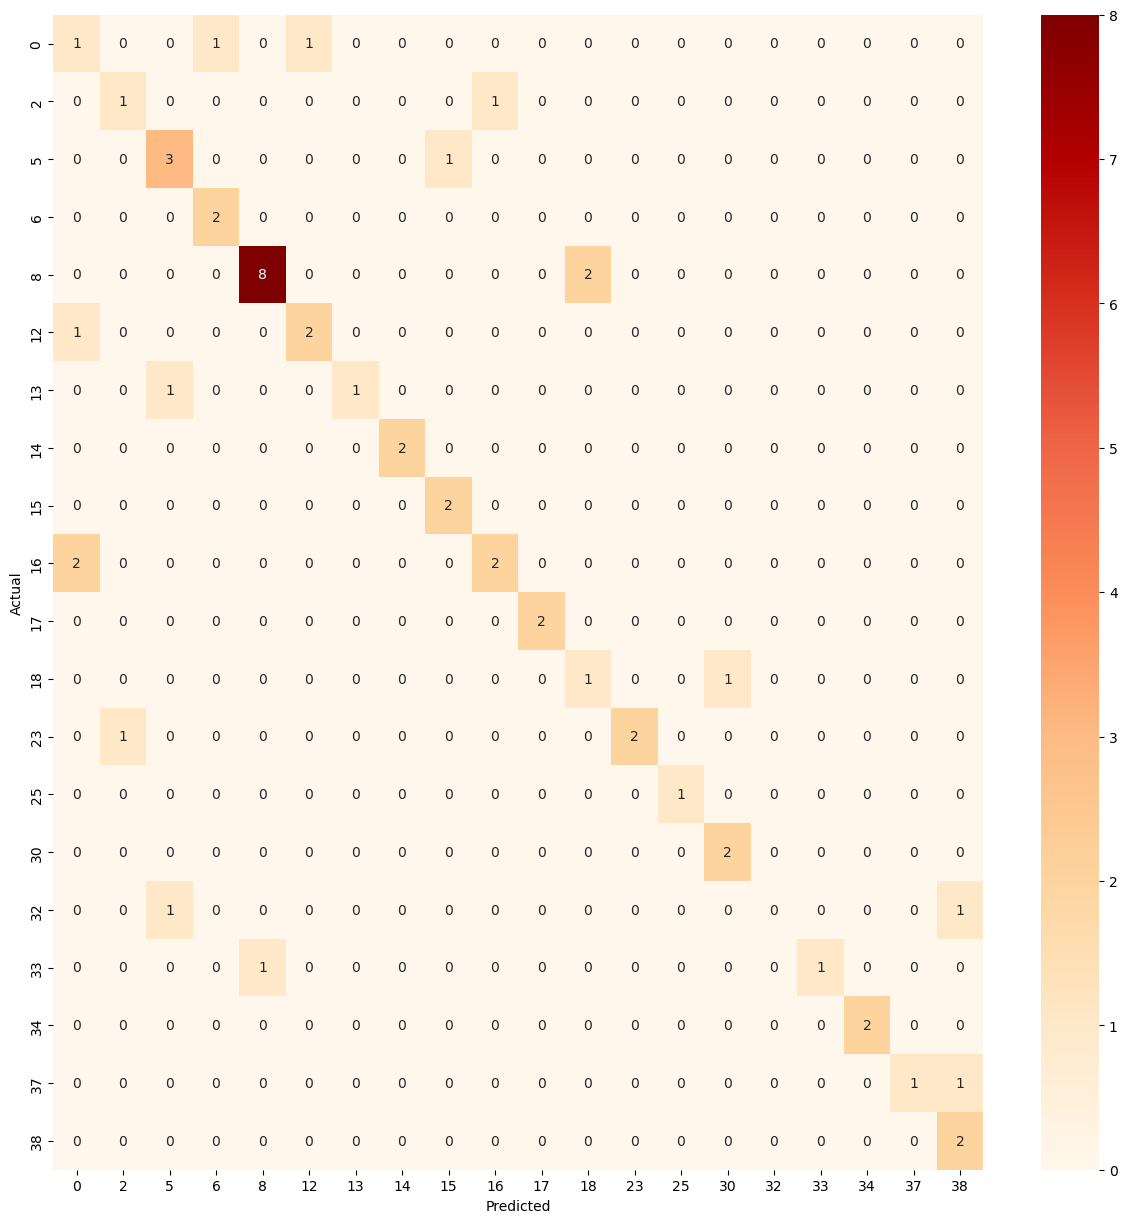

In [127]:
model = LinearSVC()

model.fit(X_train, y_train)
y_pred = model.predict(X_test)
from sklearn.metrics import confusion_matrix
conf_mat = confusion_matrix(y_test, y_pred)
print(sorted(list(set(labels.values))))

fig, ax = plt.subplots(figsize=(15,15))
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=sorted(list(set(labels.values))), 
            yticklabels=sorted(list(set(labels.values))),
            cmap='OrRd'
            )
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.savefig("../../figures/tfidf_linsvc_wo_paraphrase_confusion_matrix.png", bbox_inches='tight')
plt.show()

In [128]:
from sklearn import metrics

some_key = tfidf_w_question['op_id'].unique().astype('str').tolist()
print(some_key)
print('accuracy %s' % metrics.accuracy_score(y_pred, y_test))
report = metrics.classification_report(y_test, y_pred, target_names=some_key, output_dict=True)
report_ = metrics.classification_report(y_test, y_pred, target_names=some_key)
report_df = pd.DataFrame(report).transpose()
report_df.to_excel("../../data/processed/classification_wo_paraphrase_report.xlsx")
print(report_)

['32', '0', '12', '13', '37', '16', '2', '8', '6', '38', '17', '33', '25', '34', '18', '30', '23', '14', '5', '15']
accuracy 0.7037037037037037
              precision    recall  f1-score   support

          32       0.25      0.33      0.29         3
           0       0.50      0.50      0.50         2
          12       0.60      0.75      0.67         4
          13       0.67      1.00      0.80         2
          37       0.89      0.80      0.84        10
          16       0.67      0.67      0.67         3
           2       1.00      0.50      0.67         2
           8       1.00      1.00      1.00         2
           6       0.67      1.00      0.80         2
          38       0.67      0.50      0.57         4
          17       1.00      1.00      1.00         2
          33       0.33      0.50      0.40         2
          25       1.00      0.67      0.80         3
          34       1.00      1.00      1.00         1
          18       0.67      1.00      0.80  

/Users/heejinchae/opt/anaconda3/envs/torch/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/heejinchae/opt/anaconda3/envs/torch/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/heejinchae/opt/anaconda3/envs/torch/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

# Visualize w/ PCA, LDA & T-SNE

## LDA 
ㄹ벨이 있는 경우엔 이걸  쓰는게 맞음

In [129]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn import preprocessing
from sklearn.manifold import TSNE


from matplotlib.ticker import NullFormatter
from sklearn import manifold
from time import time

In [130]:
X = tfidf_w_question.drop(columns=["Question","processed_question","op_id"])
y = tfidf_w_question["op_id"]
target_names = y.unique()
pca = PCA(n_components=2)
X_r = pca.fit(X).transform(X)
df_x_r = pd.DataFrame(X_r)
df_x_r.columns = ["pca1","pca2"]
df_x_r["labels"] = y

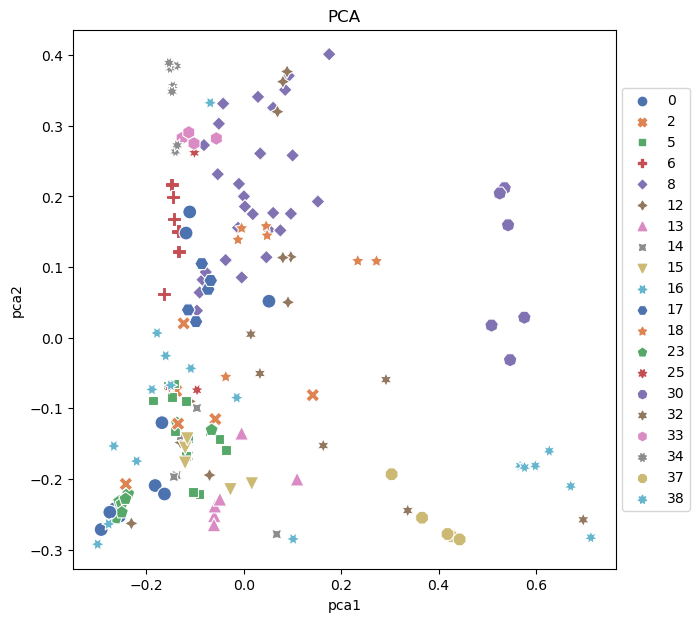

In [131]:
plt.figure(figsize=[7,7])
g= sns.scatterplot(data = df_x_r, x="pca1", y="pca2", hue="labels", style="labels", palette="deep", s=100)
plt.title("PCA")
plt.legend(loc='center left', bbox_to_anchor=(1.0,0.5), ncol=1)
plt.show()

In [132]:
lda = LinearDiscriminantAnalysis(n_components=2)
X_r2 = lda.fit(X,y).transform(X)
print(X_r2[0])
df_x_r2 = pd.DataFrame(X_r2)
df_x_r2.columns = ["pca1","pca2"]
df_x_r2["labels"] = y

[-9334.83308754  2851.63808276]


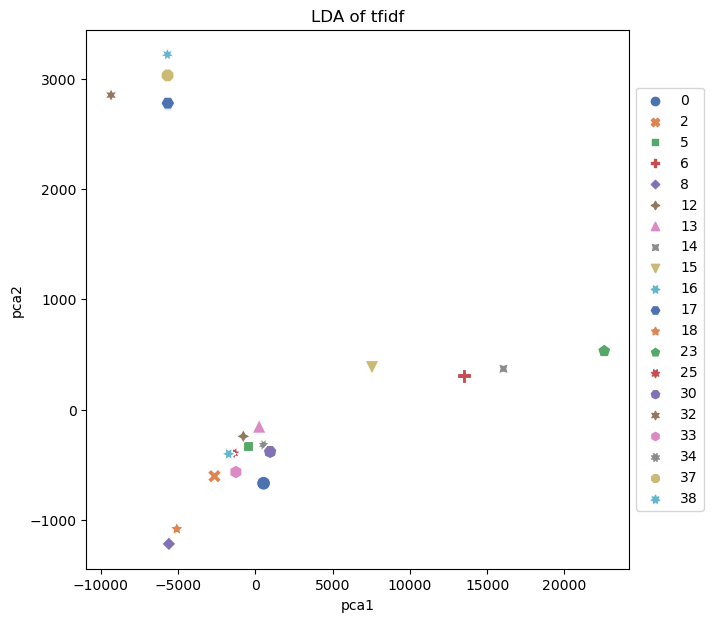

In [133]:
plt.figure(figsize=[7,7])
sns.scatterplot(data = df_x_r2, x="pca1", y="pca2", hue="labels",style="labels", palette="deep", s=100)
plt.title("LDA of tfidf")
plt.legend(loc='center left', bbox_to_anchor=(1.0,0.5), ncol=1)
plt.show()

## T-SNE

In [134]:
X_t_sne = TSNE(n_components=2, learning_rate='auto', init='random', perplexity=3).fit_transform(X)
X_t_sne

array([[ 13.275883 ,  -3.776319 ],
       [ 21.411451 ,   4.735542 ],
       [ 19.649551 ,   2.6873665],
       [  9.432099 ,  -8.225412 ],
       [  7.3468027,  -4.4770985],
       [  8.626492 ,  -5.092857 ],
       [ 24.064827 ,  17.781534 ],
       [ -2.4805999,  -9.533079 ],
       [-39.58072  ,  11.400893 ],
       [ 32.284718 , -31.414757 ],
       [-23.485516 , -31.238935 ],
       [-34.205948 ,  -3.9961202],
       [ 54.548065 ,  26.444061 ],
       [-35.060528 ,  -7.063238 ],
       [ -6.8421674,  19.171646 ],
       [ -7.6904626,  10.889224 ],
       [ -6.536451 ,  18.527422 ],
       [ -6.6874604,  20.14458  ],
       [ -6.765111 ,  11.872089 ],
       [ -7.7680225,  11.642793 ],
       [-12.053972 ,  15.587131 ],
       [-11.2898855,  15.233293 ],
       [-31.60274  , -28.10941  ],
       [-32.37785  , -28.03636  ],
       [-34.511684 , -27.375254 ],
       [-40.64017  ,  10.331037 ],
       [-32.261696 , -26.632444 ],
       [-34.078716 ,  -5.2102227],
       [-37.15629  ,

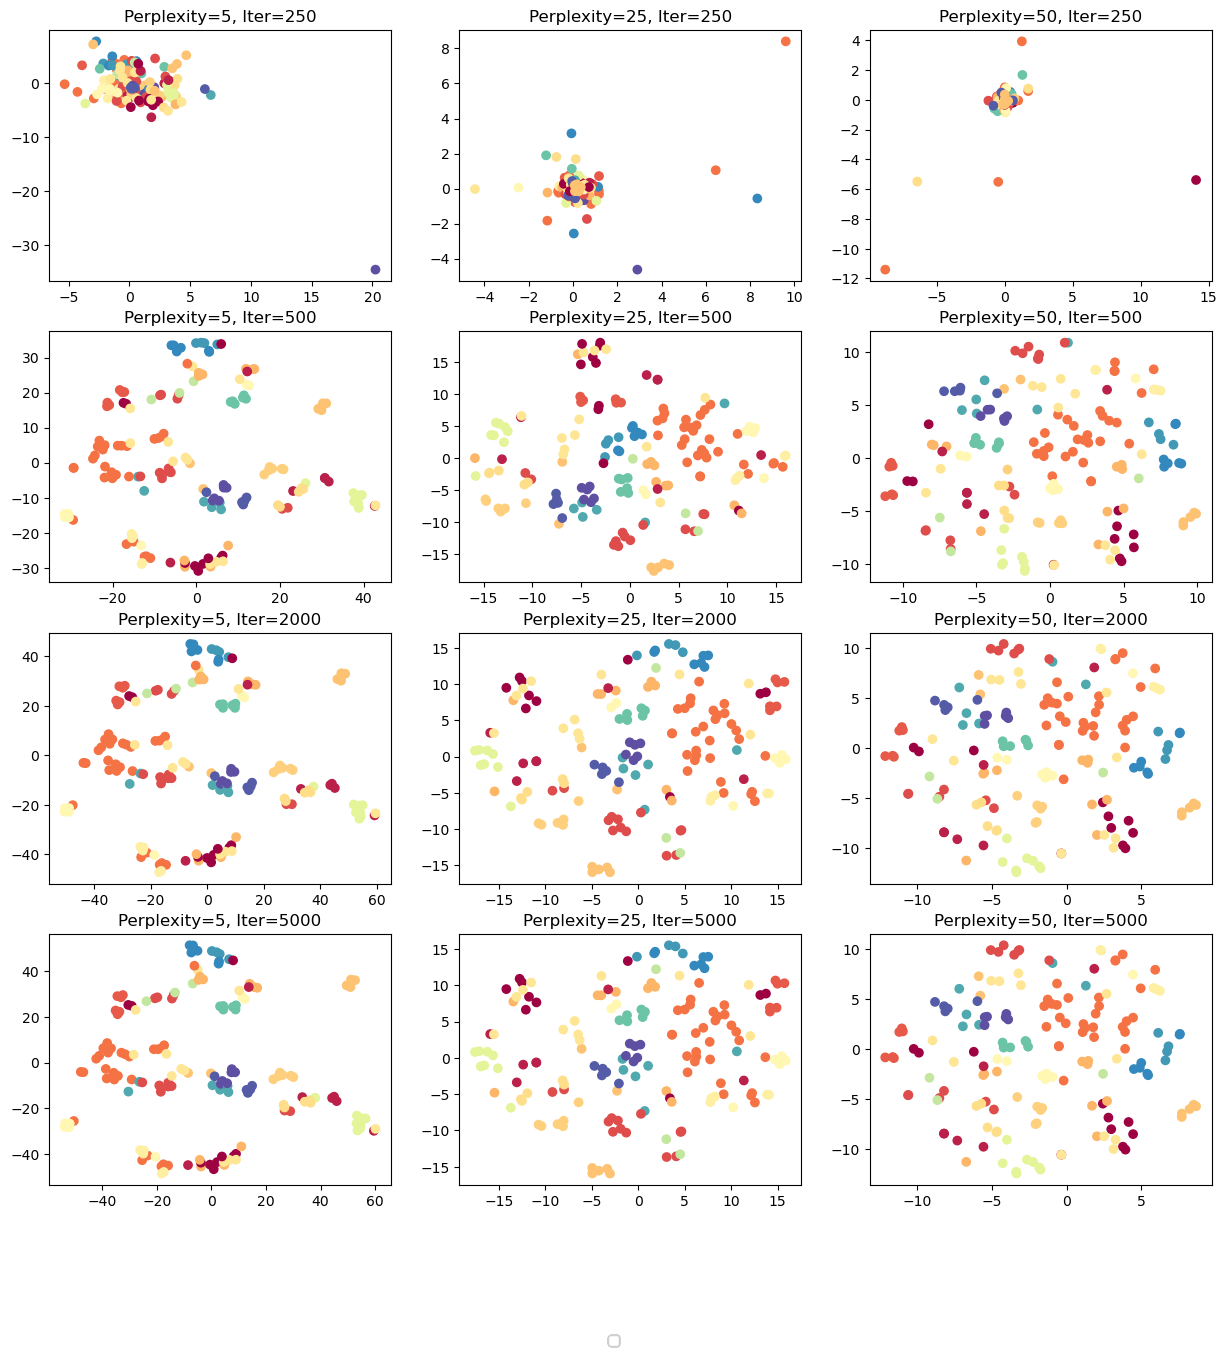

In [135]:
(fig, subplots) = plt.subplots(4, 3, figsize=(15,15))
perplexities = [5, 25, 50]
n_iters = [250,500,2000,5000]

for i, n_iter in enumerate(n_iters):
    for j, perplexity in enumerate(perplexities):
        ax=subplots[i][j]
        tsne = manifold.TSNE(
            n_components=2,
            init="random",
            random_state=235,
            perplexity=perplexity,
            learning_rate='auto',
            n_iter=n_iter,
        )
        Y = tsne.fit_transform(X)
        ax.set_title(f"Perplexity={str(perplexity)}, Iter={str(n_iter)}")
        ax.scatter(Y[:,0], Y[:, 1], c=y.to_numpy(), cmap="Spectral" )
        handles, labels = ax.get_legend_handles_labels()
        fig.legend(handles, labels, loc="lower center")

plt.savefig("../../figures/t-sne_process_wo_paraphrase.png", bbox_inches="tight")
plt.show()



## T-SNE final choice

In [136]:

tsne = manifold.TSNE(
            n_components=2,
            init="random",
            random_state=235,
            perplexity=50,
            learning_rate='auto',
            n_iter=5000,
)
Y = tsne.fit_transform(X)
t_sne_df = pd.DataFrame(Y)
X_train, X_test, y_train, y_test = train_test_split(Train_test_df.drop(columns=["op_id"]),Train_test_df["op_id"], test_size=0.2, stratify=Train_test_df["op_id"], random_state=223)
t_sne_df.columns = ["x","y"]
t_sne_df["op_id"] = tfidf_w_question["op_id"]
t_sne_df.loc[X_test.index,"for train"]= False
t_sne_df.loc[X_train.index,"for train"]= True
print(t_sne_df.head())
t_sne_df["for train"] = t_sne_df["for train"].apply(lambda x : "Train set" if x == True else "Test set") 




          x          y  op_id for train
0 -6.712607   3.473001     32      True
1  3.947447 -10.067937      0      True
2 -6.728551 -11.293741     12      True
3 -7.195027   6.043426     32     False
4 -5.785410   5.356466     13      True


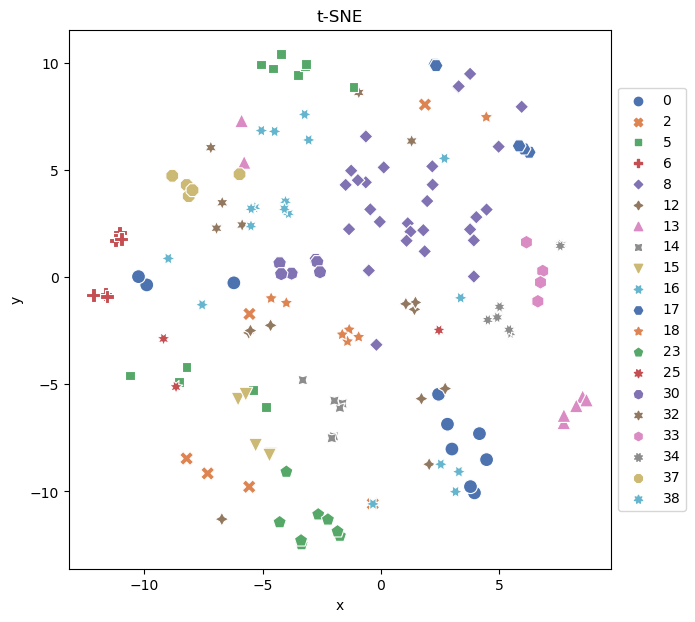

In [137]:
plt.figure(figsize=[7,7])

sns.scatterplot(data=t_sne_df, x="x", y="y", hue="op_id", style="op_id", palette="deep", s=100)


plt.title("t-SNE")
plt.legend(loc='center left', bbox_to_anchor=(1.0,0.5), ncol=1)
plt.savefig("../../figures/t-sne_on_wo_paraphrase.png", bbox_inches="tight")

plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


<Figure size 700x700 with 0 Axes>

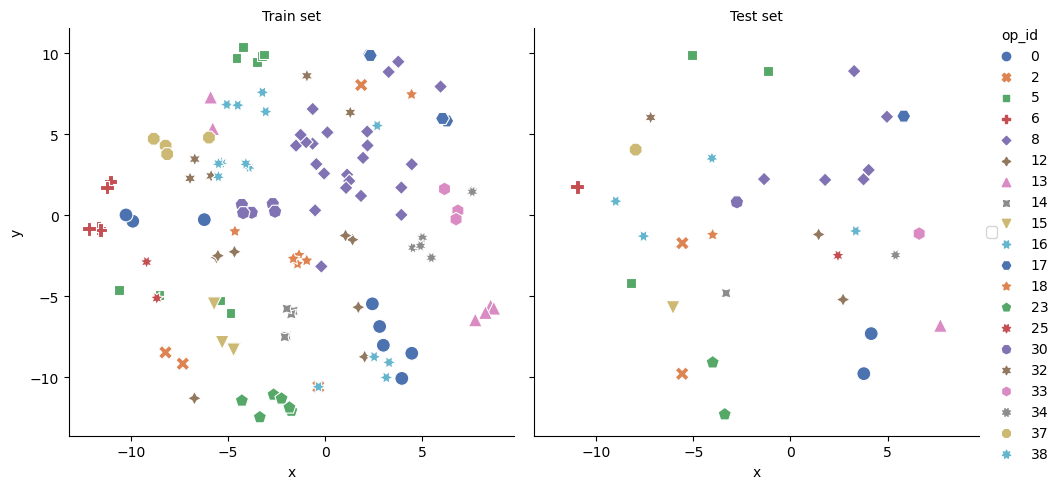

In [138]:
plt.figure(figsize=[7,7])

# sns.scatterplot(data=t_sne_df, x="x", y="y", hue="op_id", style="op_id", palette="deep", s=100)
sns.relplot(data=t_sne_df, x="x", y="y",
            col="for train", hue="op_id", style="op_id" ,
            palette="deep", s=100
).set_titles(col_template="{col_name}")

plt.legend(loc='center left', bbox_to_anchor=(1.0,0.5), ncol=1)

plt.show()